In [17]:
from configparser import ConfigParser
from string import ascii_uppercase
import pandas as pd
import requests
import json
import io

- [Chart](http://xlsxwriter.readthedocs.io/chart.html)
- [Image](http://xlsxwriter.readthedocs.io/example_images.html)

In [71]:
def template(writer, name, nen_type, ability, statistics, colour, picture):
    df_start_row = 6+len(ability) if len(ability)>5 else 11
    sheet_name = name
    
    ### WRITE DF to SHEET ###
    statistics.to_excel(writer, sheet_name=sheet_name, startrow = df_start_row, startcol=1, index=None)

    workbook  = writer.book
    worksheet = writer.sheets[sheet_name]

    worksheet.set_column('A:A', 0.5)
    worksheet.set_column('B:B', 28)
    worksheet.set_column('I:I',2)
    worksheet.set_row(0,8)
    
    ### DEFINE FORMAT ###
    title_format = workbook.add_format({
            'font_size':20,
             'bold':1})

    header_format = workbook.add_format({
            'border':True,
            'bg_color': colour,
            'font_size':12})

    merge_format = workbook.add_format({
            'border':1,
            'fg_color': colour,
            'font_size':'9'})

    border_format = workbook.add_format({
            'border':True,
            'border_color':'#73936F',
            'font_size':'10'})
    
    ### FORMAT MERGE COLUMNS ###
    worksheet.merge_range('B3:D3',name, title_format)
    worksheet.merge_range('B4:D4','Abilities', header_format)
    worksheet.merge_range('B{0}:H{0}'.format(df_start_row),'Statistics', header_format)
    
    for i, skill in enumerate(ability.items()):
        n = i+5
        worksheet.write('B{0}'.format(n),skill[0], border_format)
        worksheet.merge_range('C{0}:D{0}'.format(n),skill[1], border_format)

    worksheet.conditional_format('B{}:H{}'.format(df_start_row, df_start_row+len(statistics)+1),\
                                {'type':'no_blanks','format':border_format})
    
    #### ADD CHART ###
    chart = workbook.add_chart({'type': 'column'})

    chart.set_title({'name': 'Statistics',
                    'name_font':{'name': 'Calibri'}})

    chart.set_y_axis({
        'name': 'Points',
        'name_font': {'name': 'Calibri','size': 14, 'bold': True},
        'major_unit': 1,
    })
    
    chart.set_legend({'position': 'bottom'})
    chart.set_chartarea({
        'border': {'none': True},
        'fill':   {'color': colour}
    })
    start_row = df_start_row+2
    end_row = df_start_row+len(statistics)+1
    for i in ascii_uppercase[2:8]:
        chart.add_series({
            'name' : "='{2}'!${0}${1}".format(i,start_row-1,sheet_name),
            'categories': "='{2}'!$B${0}:$B${1}".format(start_row,end_row,sheet_name),
            'values': "='{3}'!${0}${1}:${0}${2}".format(i,start_row,end_row,sheet_name)})

    worksheet.insert_chart('J3', chart)

    ### ADD IMAGE ###
    pic = requests.get(picture)
    image_data = io.BytesIO(pic.content)
    worksheet.insert_image('F2', url, {'image_data': image_data,'x_scale': 0.5, 'y_scale': 0.5})

    return writer

In [72]:
def extract_stat(json, conf_dict):
    stat = json['statistics']
    statistics = pd.DataFrame.from_records(stat)\
                [['Story Arcs','Spirit','Skill','Strength','Nen','Talent','Intelligence']]
    statistics[[i for i in statistics.columns if i != 'Story Arcs']] = \
            statistics[[i for i in statistics.columns if i != 'Story Arcs']]\
                .applymap(lambda x: int(x) if x else 0)
    statistics = statistics.rename(columns={'Intelligence':'Int'})
    json['statistics'] = statistics
    json.update(dict(conf_dict))
    return json

In [73]:
writer = pd.ExcelWriter('HunterxHunter.xlsx', engine='xlsxwriter')

hunter_json = json.loads(open('hunter.json','r').read())
hunter_conf = ConfigParser()
hunter_conf.read('hunter.ini')

for char_json in hunter_json:
    try:
        char_json = extract_stat(char_json, hunter_conf[char_json['name']])
        template(writer, **char_json)
    except Exception as e:
        print(char_json['name'],e)
        
writer.save()

---
# Output Result

- The Templates Produced looks like this

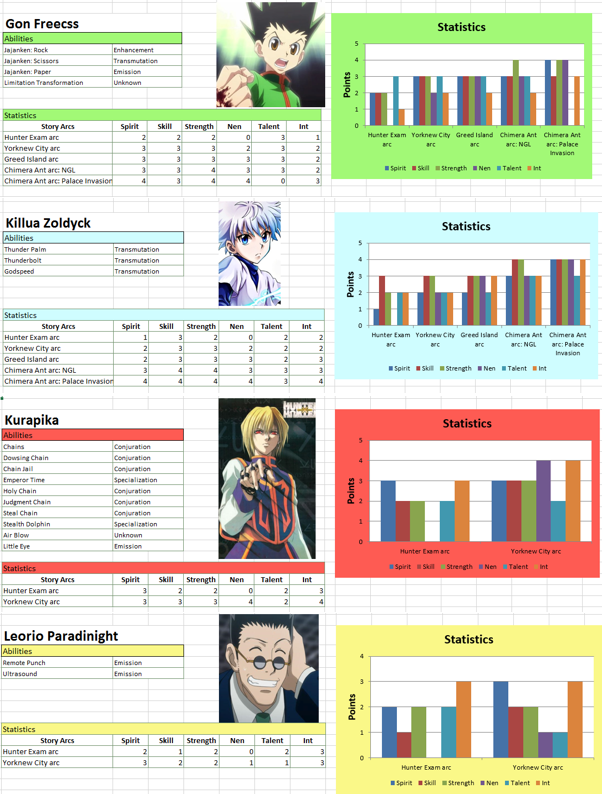

In [76]:
from IPython.display import Image
Image('hunter_biography.png')